In [13]:
import os
import sys

sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))

In [14]:
ROOT = os.path.join(os.path.dirname("__file__"), '..')

In [15]:
WEIGHTS = os.path.join(ROOT, "./weights/yolov6m_seg.pt")

# Load Image

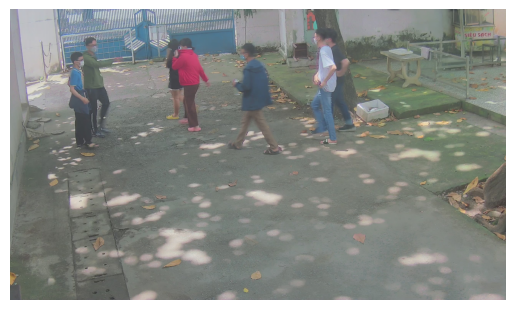

In [16]:
import os
import cv2
import matplotlib.pyplot as plt

image_origin = cv2.imread(os.path.join(ROOT, "inference/images/1475e7c3-c862-4482-86b9-005e7e411c8e.jpeg"))

plt.imshow(cv2.cvtColor(image_origin, cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.show()


# Load Model

In [17]:
import torch
from yolov6.utils.checkpoint import load_checkpoint

model = load_checkpoint(WEIGHTS, map_location=torch.device("cpu"))
model.eval()

Loading checkpoint from .././weights/yolov6m_seg.pt

Fusing model...


Model(
  (backbone): CSPBepBackbone(
    (stem): RepVGGBlock(
      (nonlinearity): ReLU(inplace=True)
      (se): Identity()
      (rbr_dense): ConvModule(
        (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
      (rbr_1x1): ConvModule(
        (conv): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2))
      )
    )
    (ERBlock_2): Sequential(
      (0): RepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (rbr_dense): ConvModule(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        )
        (rbr_1x1): ConvModule(
          (conv): Conv2d(48, 96, kernel_size=(1, 1), stride=(2, 2))
        )
      )
      (1): BepC3(
        (cv1): ConvBNReLU(
          (block): ConvModule(
            (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): ReLU(inplace=True)
          )
        )
        (cv2): ConvBNReLU(
          (block): ConvModule(
            (conv

# Pre-processing

In [18]:
import numpy as np
import torch
from yolov6.data.data_augment import letterbox

image = letterbox(image_origin, 640, stride=32)[0]
image = image.transpose((2, 0, 1))  # HWC to CHW
image = torch.from_numpy(np.ascontiguousarray(image))
image = image.float()
image /= 255
image.shape

torch.Size([3, 640, 640])

# Forward

In [19]:
with torch.no_grad():
    pred_results = model(image.unsqueeze(dim=0))[0]
pred_results[0].shape, pred_results[1][0].shape, pred_results[2].shape

(torch.Size([1, 8400, 85]),
 torch.Size([1, 32, 160, 160]),
 torch.Size([1, 8400, 33]))

# Post processing

## Using RoiAlign

In [20]:
from yolov6.utils.nms import non_max_suppression_seg

loutputs = non_max_suppression_seg(
    pred_results,
    conf_thres=0.3,
    iou_thres=0.45,
    classes=None,
    agnostic=False,
    max_det=300,
)[0]
loutputs.shape

torch.Size([11, 39])

In [21]:
det_bbox = loutputs[:, :4]
det_conf = loutputs[:, 4]
det_cls = loutputs[:, 5]
det_mask = loutputs[:, 7:]
protos = pred_results[1][0]
(
    det_bbox.shape,
    det_conf.shape,
    det_cls.shape,
    det_mask.shape,
    protos.shape,
)

(torch.Size([11, 4]),
 torch.Size([11]),
 torch.Size([11]),
 torch.Size([11, 32]),
 torch.Size([1, 32, 160, 160]))

In [22]:
mask_resolution = 56

In [23]:
from torchvision.ops import roi_pool, roi_align

pooled_proto = roi_align(
    protos.float(),
    [det_bbox.float()],
    (mask_resolution, mask_resolution),
    0.25,
    sampling_ratio=-1,
    aligned=True,
)
pooled_proto.shape

torch.Size([11, 32, 56, 56])

In [24]:
masks = det_mask.view(-1, 1, 32) @ pooled_proto.view(
    -1, 32, mask_resolution * mask_resolution
)
masks = (
    masks.view(-1, mask_resolution * mask_resolution)
    .view(-1, mask_resolution, mask_resolution)
    .sigmoid()
)
masks.shape, masks.min(), masks.max()

(torch.Size([11, 56, 56]), tensor(5.35618e-07), tensor(0.99988))

In [25]:
from torchvision.models.detection.roi_heads import paste_masks_in_image

pred_masks = paste_masks_in_image(
    masks.reshape(-1, 1, mask_resolution, mask_resolution), det_bbox, (640, 640)
)
pred_masks[pred_masks < 0.5] = 0
pred_masks[pred_masks > 0.5] = 1

pred_masks = pred_masks.reshape(-1, 640, 640)
pred_masks.shape

torch.Size([11, 640, 640])

In [26]:
masks, det_bbox, det_cls, det_conf = (
    pred_masks.cpu().numpy(),
    det_bbox.cpu().numpy(),
    det_cls.cpu().numpy(),
    det_conf.cpu().numpy(),
)
masks = masks.astype(bool)
masks.shape

(11, 640, 640)

In [27]:
nimg = image.permute(1, 2, 0) * 255
nimg = nimg.cpu().numpy().astype(np.uint8)
nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)

pnimg = nimg.copy()
print(pnimg.shape)

(640, 640, 3)


In [28]:
for one_mask, bbox, cls, conf in zip(masks, det_bbox, det_cls, det_conf):
    if conf < 0.25:
        continue

    color = [np.random.randint(255), np.random.randint(255), np.random.randint(255)]

    pnimg[one_mask] = pnimg[one_mask] * 0.5 + np.array(color, dtype=np.uint8) * 0.5

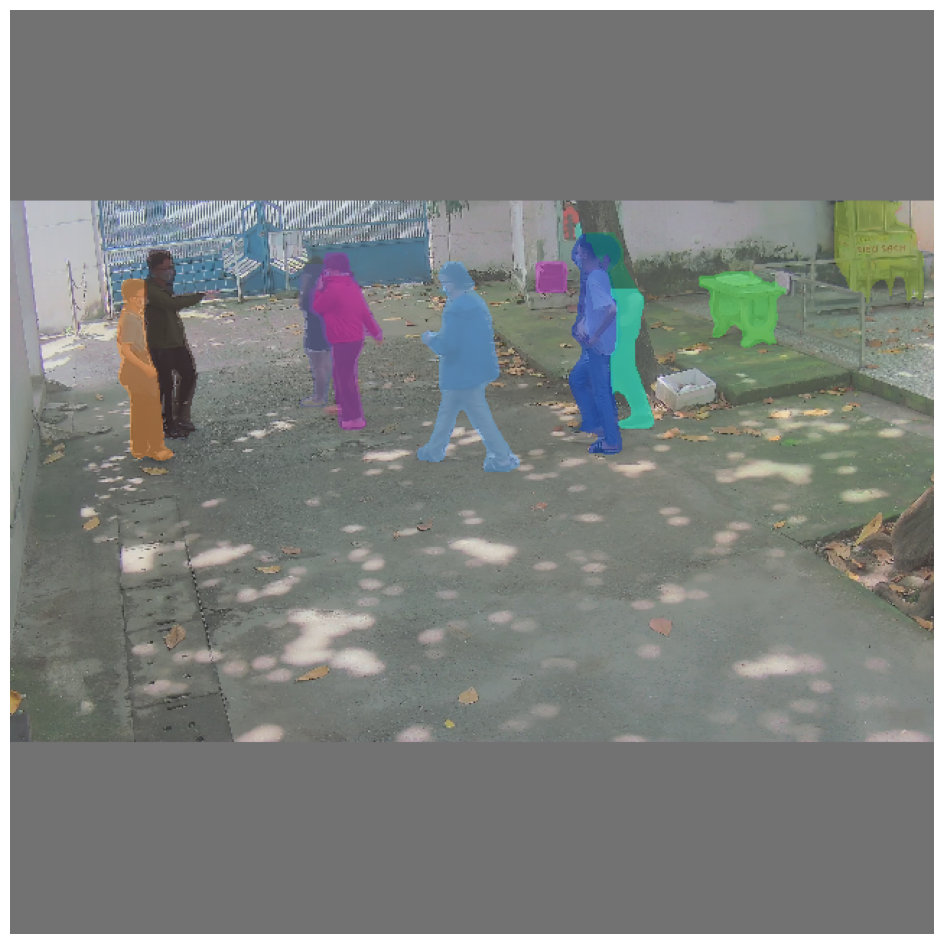

In [29]:
# coco example
%matplotlib inline
plt.figure(figsize=(12, 12))
plt.axis("off")
plt.imshow(pnimg)
plt.show()